In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from import_file import *
load_libs()

In [2]:
import mpld3
from mpld3 import plugins
from jinja2 import Template
# mpl.rcParams['figure.figsize'] = 3,3

# 1. Data Wrangling

In [3]:
data = []
for year in range(2010,2014):
    file = "movie_list_%s_v2.json" % year
    with open(file ) as data_file:    
        data += json.load(data_file)
    
df = pd.DataFrame(data)
df.describe()

D:\Program Files\Anaconda2\lib\site-packages\pandas\core\algorithms.py:348: RuntimeWarning: tp_compare didn't return -1 or -2 for exception
  keys, counts = htable.value_count_object(values, mask)


,detail_url,douban_info,movie_tt_id,name,omdb_info
count,2064,2028,2064,2064,2064
unique,2041,2012,2041,2037,2038
top,http://www.movieinsider.com/m11397/desperate-a...,"{u'rating': {u'max': 10, u'average': 0, u'star...",tt1714866,Starbuck,"{u'Response': u'False', u'Error': u'Incorrect ..."
freq,2,2,2,2,4


In [4]:
# Problem, handling unicode json
df.drop_duplicates('movie_tt_id', inplace=True)
df['temp_string'] = df['douban_info'].astype(str)
df.drop_duplicates('temp_string', inplace=True)
df['temp_string'] = df['omdb_info'].astype(str)
df.drop_duplicates('temp_string', inplace=True)
df = df.dropna()
df.drop('temp_string', 1, inplace=True)
df.drop('detail_url', 1, inplace=True)
df.describe()

,douban_info,movie_tt_id,name,omdb_info
count,2003,2003,2003,2003
unique,2003,2003,1999,2003
top,"{u'rating': {u'max': 10, u'average': 7, u'star...",tt1860152,Frozen,{u'Plot': u'As inventor Andy Brewster is about...
freq,1,1,2,1


In [5]:
df['omdb_info'][0]

{u'Actors': u"Harriet Minto-Day, Jay Laga'aia, Damien Garvey, Sahaj Dumpleton",
 u'Awards': u'4 wins & 5 nominations.',
 u'Country': u'Australia, USA',
 u'Director': u'Michael Spierig, Peter Spierig',
 u'Genre': u'Action, Fantasy, Horror',
 u'Language': u'English',
 u'Metascore': u'57',
 u'Plot': u'In the year 2019, a plague has transformed almost every human into vampires. Faced with a dwindling blood supply, the fractured dominant race plots their survival; meanwhile, a researcher works with a covert band of vamps on a way to save humankind.',
 u'Poster': u'http://ia.media-imdb.com/images/M/MV5BNzg3NDYyMDU4Nl5BMl5BanBnXkFtZTcwODA5NzA5Mg@@._V1_SX300.jpg',
 u'Rated': u'R',
 u'Released': u'8 Jan 2010',
 u'Response': u'True',
 u'Runtime': u'98 min',
 u'Title': u'Daybreakers',
 u'Type': u'movie',
 u'Writer': u'Michael Spierig, Peter Spierig',
 u'Year': u'2009',
 u'imdbID': u'tt0433362',
 u'imdbRating': u'6.5',
 u'imdbVotes': u'98623'}

In [6]:
# Data problems
# 1.['imdb_info']['imdbRating'] do not exist
# 2.['imdb_rating'] is 'N/A', at id 108, 273
# 3.['imdb_rating'] is '23,421', need to get rid of the comma

df['imdb_rating'] = df['omdb_info'].apply(lambda x: x.get('imdbRating', np.nan))
df['metascore'] = df['omdb_info'].apply(lambda x: x.get('Metascore', np.nan))
df = df.dropna()
df = df[(df.imdb_rating != 'N/A') &(df.metascore != 'N/A')]
df['imdb_ratings_count'] = df['omdb_info'].apply(lambda x: int(x['imdbVotes'].replace(',', '')))
df['db_rating'] = df['douban_info'].apply(lambda x: x['rating']['average'])
df['db_ratings_count'] = df['douban_info'].apply(lambda x: x['ratings_count'])
df['imdb_rating'] = df['imdb_rating'].astype(float)
df['imdb_ratings_count'] = df['imdb_ratings_count'].astype(float)
df['name'] = df['name'].apply(lambda x: x.encode('ascii','ignore'))
df['metascore'] = df['metascore'].astype(float)
df['metascore'] = df['metascore']/10
df['genre']=df['omdb_info'].apply(lambda x: x.get('Genre', 'none'))
df['image_url']=df['omdb_info'].apply(lambda x: x.get('Poster', 'none'))
df['douban_url']=df['douban_info'].apply(lambda x: x['alt'])

df.drop('douban_info', 1, inplace=True)
df.drop('omdb_info', 1, inplace=True)

# 2. Movie Overview

In [7]:
df.describe()

,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count
count,1662.000000,1662.000000,1.662000e+03,1662.000000,1662.000000
mean,6.386282,5.514019,5.268382e+04,5.901986,18715.155235
std,0.988046,1.703777,1.050602e+05,2.532974,46304.546623
min,1.600000,0.100000,1.200000e+01,0.000000,0.000000
25%,5.800000,4.300000,1.895500e+03,5.800000,131.500000
50%,6.500000,5.550000,9.648000e+03,6.600000,2010.500000
75%,7.100000,6.700000,5.588025e+04,7.500000,12730.750000
max,8.900000,10.000000,1.255291e+06,9.300000,586362.000000


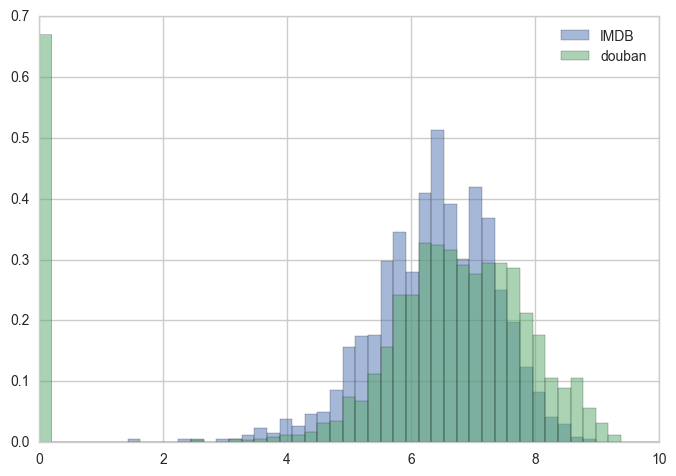

In [8]:
# bins=arange(-0.05,10,0.1)
bins=linspace(0,10)
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins, alpha=0.5,  normed=True, label = 'douban')
plt.legend()

可以发现，有的电影豆瓣电影没有分数。应该把这些去掉

（可以看看这些电影是什么样的）

## 2.1 Empty Score Moives

In [9]:
empty_df = df.query('db_rating == 0')
display(empty_df.describe())
fig=plt.figure()
empty_df['imdb_rating'].hist(bins=arange(-0.05,10,0.1), alpha=0.5)
plt_configure(title='No Douban rating, IMDB Rating Distribution',figsize=(3,2))
fig=plt.figure()
empty_df['imdb_ratings_count'].hist(bins=50)
plt_configure(title='No Douban rating, IMDB Rating Count Distribution', figsize=(3,2))
align_figures()

,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count
count,227.000000,227.000000,227.000000,227.0,227.000000
mean,6.070925,5.250220,628.911894,0.0,7.048458
std,1.137316,1.645465,1053.300889,0.0,6.173906
min,2.300000,0.900000,12.000000,0.0,0.000000
25%,5.500000,4.150000,168.500000,0.0,2.000000
50%,6.200000,5.400000,391.000000,0.0,5.000000
75%,6.900000,6.500000,726.000000,0.0,12.000000
max,8.400000,8.600000,13492.000000,0.0,23.000000


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAVUAAADWCAYAAABhXxHsAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAPYQAAD2EBqD+naQAAIABJREFUeJzt3XdcU/f6B/BP2AiIgCxRi1orQ0BEQMVREbW47W1rFa16
Vaqi1Cu1Am5FRdHiQJHhplqsllq3dVS9FsXiddS6AMEFMkSGhMSE8/uDX04JCSMQOIk+79eLV8jJ
yfc8Z+TJ94ych8cwDANCCCFKocF1AIQQ8i6hpEoIIUpESZUQQpSIkiohhCgRJVVCCFEiSqqEEKJE
lFQJIUSJKKkSQogSUVIlhBAlUiipTpw4EY6Ojrh7967c1729vRESEtLooLy9vWFnZ8f+OTg4wN3d
HePHj8eRI0ca3X5NtmzZAjs7uyZrvykJhUKsWbMGx44dY4eFhIRg4MCBnMU0ceJEfPXVV+zzqKgo
2NnZwcXFBW/evJH7ngMHDsDOzk4q7pCQEKntwd7eHq6urhgxYgS2bt0KgUAg1Ub18e3s7ODm5oax
Y8fit99+qzPu6tufZBv08PCAn58fLl++rPCyOH/+PBYsWMA+T0lJgZ2dHa5fv65wW4qSTKvqn5OT
E/r164egoCCkp6dLjZ+UlAR7e3u8ePGiXu2XlJRgwYIF+PPPP2sd7/nz57Czs8Mvv/wCAPj5559h
Z2dX7+nUhsvlW52Wom+oqKhAcHAwkpKSoKWl8Nvr7eOPP8asWbMAACKRCK9evcLJkyexYMEC3L9/
X2oBKguPxwOPx1N6u80hLy8Pe/bsQXh4ODts1qxZmDRpEodRyScSiXDhwgUMHz5c5rUTJ07IXQfm
5ubYunUrgMptsKSkBH/++SdiYmJw5coV7N69Gzo6OjWOX1RUhGPHjiEwMBA7d+5Er169ao2x6vYn
ifnJkyeIiYnBrFmzcOjQIXTp0qXe87xr1y6p+XJ0dMTBgwfRqVOnerfRGDweD0uXLoWDgwMAoLy8
HE+ePEF8fDw+++wz7NmzB87OzgAq5z0xMRHm5ub1avvevXs4cuQIPvvss1rHMzc3x8GDB9GuXTs2
JmV93rhevlUpnBWNjIyQlpaGqKgozJ07tyliAgCYmJiwK1nCx8cH5ubm2L17NwYPHgxXV9cmm766
kXcLB8nGq2q6d++OkydPyiTV3NxcpKamwt7eHkVFRVKv6ejoyGwPffv2hbOzMwICArBr1y58/fXX
tY7fv39/3LhxA4mJiXUmVXnbX/fu3eHs7IyhQ4fi6NGjCiXV6gwMDGTab2qdOnWSmqaHhwc++eQT
jBkzBsHBwTh+/Dh4PB5MTExgYmJS73YZhqlXcpS3TpoKF8tXQuFjqnZ2dhg9ejTi4+Px999/1zpu
RUUFfvjhB4wYMQIuLi4YMGAANmzYAKFQ2OCAZ8+eDR0dHfz444/sMKFQiK1bt8LX1xfOzs4YMmQI
4uLipBKNvEMTNe1+nD17FkOGDIGzszO++OILJCcnS73+4MEDzJkzB7169ULXrl3Rr18/hIWFSc2X
nZ0d9u/fj0WLFsHT0xPdu3fH3Llz8erVqxrnTbJ7tHv3bvj6+sLV1RVJSUlsTH5+fujevTucnJzg
6+uLH374gX2fj48PeDwegoOD2V3n4OBgeHt7Sy2DLVu2YN26dfDy8oKLiwumTZuGrKwsqTiSkpIw
bNgwODs7Y/To0UhOToajoyO729YYPB4Pvr6+uHz5sswhgFOnTqFjx44KJauBAweiW7duUttDbYyM
jBrVOzIyMgIAqTaeP3+O7777Dn379kXXrl3Ru3dvLFiwgP1imDhxIq5fv46UlBTY29uz/1fdPY2K
isLgwYNx8eJFjBw5Ek5OThgyZIjM4a6MjAxMnz4dbm5u6NOnDyIjIxEaGoqJEyc2aH4MDQ0xbdo0
PH78GNeuXQMg+7l49eoVgoKC0KdPH3abkGwLKSkp7N5Q1cM9EydOxPz58xEYGAhXV1dMnTpVZvdf
IjU1FWPGjIGTkxNGjBiBEydOsK/VtBtffVp1LV8AuHPnDqZNmwZPT0+4ublhxowZSEtLk5lWcnIy
pk6dim7duqFPnz5Yv3693E5LTRp0oio0NBQmJiYICQmBSCSqcbzFixcjPDwcQ4YMwfbt2zFhwgQk
JCRI7VYpytDQEM7OzkhNTWWHff3119i5cyfGjh2LmJgYfPLJJ9i4cSOWLl1aa1vydj8YhsGiRYsw
efJkbNmyBYaGhpg+fTp7HDkvLw9+fn7g8/kIDw9HXFwchg0bhoSEBOzZs0eqrY0bN6KiogKRkZFY
sGABLly4gFWrVtU5j1FRUfD398e6devQu3dv/P7775g9ezacnJwQHR2NqKgotG/fHmFhYbh9+zYs
LCwQFRUFhmEwa9YsdrdX3vzt3bsXGRkZCA8Px6pVq/DXX39JHUr55ZdfEBISAjc3N0RHR2PIkCEI
CAhARUVFnXHX1yeffAKxWIwLFy5IDT9x4gSGDRumcHteXl7IyclBdna21HCxWAyxWAyRSITXr19j
7969SEtLw/jx4+vVruT9YrEY5eXluHfvHr777jtoa2uzcZaXl2PixIl4/Pgxli1bhp07d2LSpEk4
fvw4IiMjAQDLli2Dg4MDHBwckJiYyO6CV183eXl5WLlyJSZPnozY2Fi0bdsWwcHBePz4MQCgsLAQ
fn5+yMnJwdq1a7Fw4UKcPn0ax44da9QXhZeXFxiGYT9T1beb+fPn4/Hjx1ixYgXi4+Ph4OCAkJAQ
pKSkwNHREUuWLGHns+pn7uTJkzA0NER0dDSmTZsmd9oMw2DJkiUYOnQooqOj8dFHH2HevHk4d+4c
O05d81af5Xv16lWMGzcOPB6P3fZzcnLw5Zdfssu36vz26NEDMTExGDFiBOLj4/HTTz/VZ1ECaMDu
P1D5bb1ixQrMnDkTW7duxTfffCMzTlpaGg4fPoxvv/2WXaC9evWCubk5vvvuO1y6dAn9+vVryOTR
unVr3LlzBwBw8eJFJCcnIzIyEr6+vux09PT0sHnzZkyaNEmh4yo8Hg8rV67EoEGD2LYGDhyI2NhY
bNq0CQ8fPoS9vT22bNkCfX19dpwrV64gJSUF06dPZ9vq0qULVq9ezT6/desWTp8+XWcMQ4cOxZgx
Y9jnx44dw6efforg4GB2WLdu3eDp6Ylr167B2dkZ9vb2AID27dvXerLN2NgY0dHR7AaXlZWFqKgo
FBUVwdjYGJs3b8bAgQOxYsUKAJUfOE1NTTZBKIOpqSnc3d2lDgE8f/4ct2/fRkREBLZt26ZQe61b
twZQmZSsra3Z9hwdHaXG4/F4GDduHNzd3etsMykpid1LkNDS0oKTkxN27drFLuPMzEy0adMGa9eu
hY2NDYDK3eqbN28iJSUFQOVut4GBAXg8ntQuafXeT3l5OVatWgVPT08AgK2tLQYMGICLFy+iQ4cO
2Lt3L/h8Pnbt2sXOs4uLC4YMGVK/BVUDybHT/Px8ua9fv34ds2fPZvd6PDw8YGJiAh0dHRgYGODD
Dz9k57PqZ01bWxvLly+HtrY2gMp1Is8333yDyZMnAwD69OmDx48fIzo6ut4nWeuzfDds2IAOHTog
NjaW3fa9vLzg4+ODzZs3S23fY8eOxcyZMwEAnp6e+O2333DhwgV88cUX9YqnwWeaBgwYgJEjRyIu
Lg6DBw9mP9QSKSkp4PF4Mj2PYcOGsd9yDU2qVY/hpKSkQEtLC5988onUOCNHjsSmTZuQkpKiUFLV
0tJiEypQeRyoX79++P333wFUrggvLy+IRCKkp6cjKysLDx8+xKtXr2SOQ7m4uEg9t7KyAp/PrzOG
6ru/U6dOBQCUlZXh8ePHyMrKwl9//QUACh9KcXJykvoGt7KyAgDw+XwUFRXhxYsXMsfKhw8fju+/
/16h6dRl6NC

In [10]:
# these 2 table can be combined with an interactive table sorting
# empty_df.sort_values(by='imdb_rating',ascending=False).head()

In [11]:
# empty_df.sort_values(by='imdb_ratings_count',ascending=False).head()

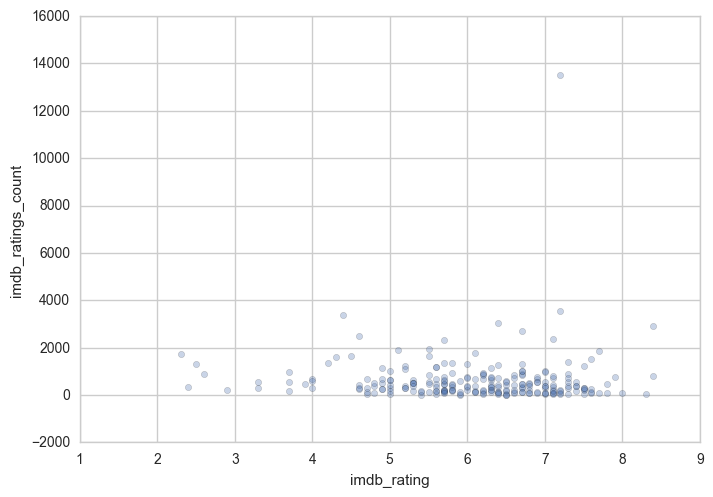

In [12]:
empty_df.plot(kind='scatter', x='imdb_rating', y='imdb_ratings_count', alpha=0.30)

## 2.2 Delete Empty movies, Go ahead

In [13]:
df = df.query('db_rating > 0')

# 3. Movie Overview (两种评分都有的)

## 3.1 Overall Info

In [14]:
df.describe()

,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count
count,1435.000000,1435.000000,1.435000e+03,1435.000000,1435.000000
mean,6.436167,5.555749,6.091829e+04,6.835610,21674.556098
std,0.953249,1.709649,1.108509e+05,1.022375,49186.918616
min,1.600000,0.100000,2.050000e+02,2.600000,20.000000
25%,5.900000,4.300000,3.924500e+03,6.200000,467.500000
50%,6.500000,5.600000,1.579300e+04,6.800000,3510.000000
75%,7.100000,6.800000,7.032400e+04,7.600000,16806.500000
max,8.900000,10.000000,1.255291e+06,9.300000,586362.000000


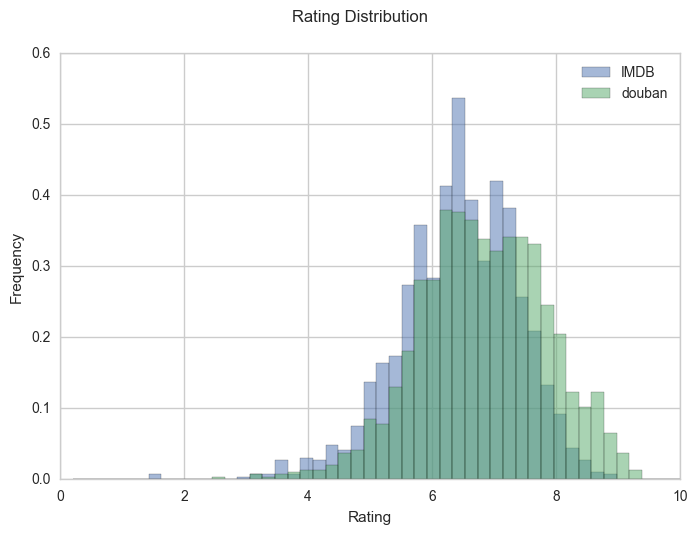

In [15]:
# 1. Why douban is higher?
# 2. Why the std is close to 1? (but IMDB < Douban, indicating a narrower distribution)
bins=linspace(0,10)
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins,alpha=0.5,  normed=True, label = 'douban')
plt_configure(xlabel='Rating',ylabel='Frequency', title='Rating Distribution', legend=True)

1. 两者大致分布正态分布，可以认为样本量基本足够
2. 这不是标准的正态分布，有偏度。原因？
3. 豆瓣电影偏高（相对有移动了）

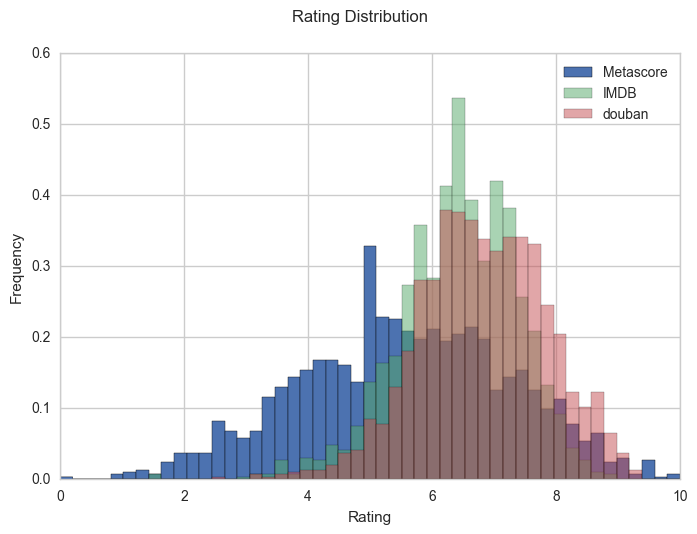

In [16]:
df['metascore'].hist(bins=bins, normed=True, label = 'Metascore')
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins,alpha=0.5,  normed=True, label = 'douban')
plt_configure(xlabel='Rating',ylabel='Frequency', title='Rating Distribution', legend=True)

并不是所有的影评分布都会类似. 比如Metascore的分布，就大为不同

Metascore的分数经过了人工的调整、加权，所以分布差别很大

## 3.2 Good Movies

Any your favorite?

### 3.2.1 Order by IMDB Rating

In [17]:
# Good Movies
# display(df.sort_values(by='imdb_rating',ascending=False).head(5))
movie_list(df.sort_values(by='imdb_rating',ascending=False))

### 3.2.2 Order by Douban Rating

In [18]:
movie_list(df.sort_values(by='db_rating',ascending=False))

## 3.3 Scatter Comparison

scatter,可以非常直观的比较两者的差别

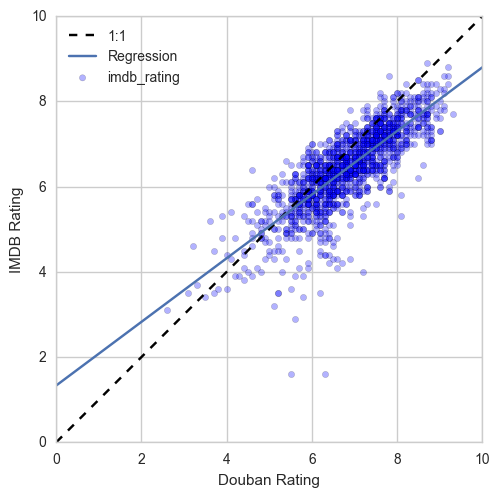

In [19]:
fig, _ , scatter_plot = plot_movie_scatter_comparison(df, title='')

In [20]:
turn_scatter_into_interactive(fig, scatter_plot, df, 'movie_compare_all.html')

D:\Program Files\Anaconda2\lib\site-packages\mpld3\mplexporter\exporter.py:171: UserWarning: Legend element <matplotlib.collections.PathCollection object at 0x000000001212B7F0> not impemented
  warnings.warn("Legend element %s not impemented" % child)


对比回归线，可以看到
1. 并不是1:1的关系，斜率不同（原因？可能是打分制？），而且分数越高，差别越大

    - IMDB: 10星制。没有人会打10星  
    - 豆瓣：5星制。4星以上都会打5星
    
    豆瓣的打分制概念简单，不需要太精确，体验更好。

2. IMDB比豆瓣要齐整得多。豆瓣确实有一些电影，偏离回归线较大[(4,6)附近]

3. Play with the scatter, 发现“打分人数”的问题

## 3.4 Rating Number Problem

In [46]:
for min_ratings_number in [0, 1000,3000,5000,10000, 20000,40000]:
    min_ratings_number = min_ratings_number
    temp_df = df.query("(db_ratings_count > @min_ratings_number) & \
                   (imdb_ratings_count > @min_ratings_number)")
    title = 'Min Rating: ' + str(min_ratings_number)
    fig, fit_params, _ = plot_movie_scatter_comparison(temp_df, title=title)
    fig.set_size_inches(2.5,2.5)
    fig.show()
    print min_ratings_number, fit_params[1], len(temp_df)
align_figures()

0 0.777875530637 822
1000 0.777875530637 822
3000 0.779117292801 735
5000 0.794122490774 609
10000 0.809228311458 436
20000 0.785245079648 303
40000 0.782214462177 190


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQsAAAEWCAYAAABxHbIXAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAPYQAAD2EBqD+naQAAIABJREFUeJzsnXl8VPW5/9/nnNmXZLKTPYEAIYEk7ApFLAougLe31i5a
ba21datre4v3Vuu1tq5dbK3WW21den+9te4oSkFRFMNiIISwBQKTQLaZLDOZfTvn98chgQhogsEE
OO/Xi1fId+ac88xkzmee5/k+3+crKIqioKGhofEZiCNtgIaGxqmBJhYaGhqDQhMLDQ2NQaGJhYaG
xqDQxEJDQ2NQaGKhoaExKDSx0NDQGBSaWGhoaAwKTSw0NDQGhSYWo5Qrr7yS0tJSvvWtbx33Obfd
dhulpaXceeed/WOlpaU89thjn+vaGzdupLS09Kh/U6ZMYf78+fz0pz+ls7NzSOeMRqPcf//9vPHG
G/1jd955J+edd97nsvXz8uyzz7Jo0SIqKyv56le/yvvvvz+i9oxmdCNtgMbxkSSJrVu30tHRQVZW
1oDHQqEQ7733HoIgDBh/4YUXjnruiSAIAj//+c8pKyvrHwsEAtTU1PDkk0/idDr5xz/+Mejzud1u
nn32WR544IH+sRtuuIHvfOc7n9vWE+Wvf/0rjzzyCD/60Y8oLy/nxRdf5IYbbuD5559n2rRpI2bX
aEUTi1FMWVkZe/fu5e233z7qplqzZg1ms5nk5OQB4xUVFcN2/XHjxh11vrPPPptIJMJTTz1FY2Mj
48aNG9S5jrUEKT8/f1jsPBEikQhPPPEE11xzDddddx0A8+bN45vf/CZ//OMfefrpp0fMttGKFoaM
YsxmM/Pnz+ftt98+6rEVK1Zw4YUXIooD/4RHhiF94UR1dTXXXHMNVVVVfOlLX+KRRx455s07WOx2
O8AAr2b16tVcccUVTJs2jSlTpnDRRRfxv//7vwC0tLRw/vnnIwgCy5Yt6w89li1bxoIFC/rPsWDB
Av7whz/w0EMPMXfuXCorK/n+979PU1PTgOu/8sorLF68mIqKCr7yla9QXV1NeXk5r7766oD34cjw
7JNs3boVn8/H+eefP2B84cKFbNiwgWg0eoLvzumLJhajnIsvvpja2lo6Ojr6x/x+P2vXrmXx4sWD
OsdPfvITZsyYwZNPPsnSpUt56qmn+Oc///mZxyUSiQH/vF4vK1eu5Omnn6ayspKxY8cC8N5773HT
TTcxZcoUnnjiCR577DEKCgq47777qKurIzMzk8ceewxFUbjhhhv44x//CKhi88kw6rnnnmPfvn08
8MAD/PKXv6S+vp6f/vSn/Y+/+uqr3HnnnUyfPp0nnniCCy64gBtvvBFZlgec54UXXuCGG2447mtr
bGwEoKioaMB4YWEhiUSC5ubmz3x/zjS0MGSUM3/+fMxm84BQZNWqVaSnpzN9+vRBneMb3/gG119/
PQCzZ89m1apVrFmzhq9//evHPUZRFK6++uqjPJDk5GTOP/98fvzjH/ePNTY28tWvfpVly5b1j1VV
VTF79mw2bNhARUUFkyZNAqCgoIDS0tLjXjc5OZknnniiX0Sampp47LHH8Hq9JCcn8/vf/57zzjuP
e++9F4C5c+ciSRK//e1vB5zns8Ixn88HgM1mGzButVoBVZA1BqKJxSjHaDTy5S9/eYBYrFixgosv
vnjQ56isrBzw+5gxYwiFQp953L333ktZWRmJRIJ33nmHp59+miuvvJKbbrppwPOuueYaAILBIPv3
76epqYn6+nqAIbvzU6ZMGeBtjBkzBlATul6vl9bWVm699dYBxyxZsoTf/OY3Q7rOZ4VhnwzvNDSx
OCW4+OKL+dGPfkRHRwdGo5Hq6mpuv/32QR0rCAJms/mosU+67cc6rqioiPLyckD9ptbr9Tz22GOY
TCa+//3v9z+3p6eHu+++m3feeQdRFCksLOz3eoaaGzGZTAN+77tpZVmmu7sbgLS0tAHPSU9PH9I1
4LBHEQgE+nMwcNij+KTHoaGJxSnBvHnzsFgsrFy5ErPZTF5eXr9b/0Vy/fXXs3r1ah599FHOPfdc
SkpKALjjjjtwOp0899xzVFZWotfrCYfDvPDCC8N6/T4v45M1Hl1dXUM+V1++pampicmTJ/ePNzU1
odfrR3SmZrSi+VqnAAaDgfPPP5+3336bt956iyVLloyIHZIkcc899xCPx7nvvvv6xzdv3syiRYuY
MWMGer0eoL+4qc+zkCTpc19/zJgxFBQUsHr16gHjK1euPCpR+llMnToVk8nEypUrB4yvWrWKWbNm
9b8OjcNonsUpwkUXXcR1112HJEncddddgz7uRKdIj3dcVVUVl1xyCa+99horV67kggsuYMqUKSxf
vpyysjLGjBlDTU0N//M//4MoigSDQeCwW19dXc3YsWNPuB7k5ptv5ic/+Qn33HMPCxcuZOfOnTz+
+OPAwKncrVu3kpqaelwPwWQycc011/D444+j0+mYOnUqL774Itu3b+dvf/vbCdl2uqN5FqOYIz/8
c+fOJSkpiQkTJlBcXDzgOUc+71i/f9a5h/r4j3/8Y2w2Gw8++CCRSIQHH3yQiooK7rvvPm666SbW
rFnDL37xC770pS9RU1MDqGJx9dVXs2rVKq699loSicRR1znWVOonWbJkCffeey/V1dVcf/31rFix
gp/97GcoitI/kwHqDFCfiByPm266iZtvvpnXXnuNm2++mZaWFv70pz9RVVX1qcedqQhad2+NU4k3
33yTsrKyAYL53nvvcf311/Paa68xYcKEEbTu9GZUeRbRaJSlS5eyadOm/rGDBw9y9dVXM3XqVJYs
WcK6detG0EKNkeb111/n2muv5Y033uDjjz/mpZde4p577mH27NmaUJxkRk3OIhqNcvvtt7N3794B
4zfeeCOlpaW89NJLrF69mptuuom33nqrPzOucWbx0EMP8etf/5pHHnmE7u5u0tPTueiii7j55ptH
2rTTnlEhFo2Njdxxxx1HjVdXV3PgwAFeeOEFjEYjP/jBD6iurubFF188qjBI48wgOTm5v3pT44tl
VIQhGzdu5Oyzz+Yf//jHgCx8XV0d5eXlGI3G/rHp06dTW1s7EmZqaJzRjArP4ngNXtxuN5mZmQPG
0tLSBiyq0tDQ+GIYFZ7F8QiFQhgMhgFjBoNBWz6soTECjArP4ngYjUa8Xu+AsWg0etT6geMRj8fx
er0YjUZtYZDGGYssy0QiEZKTk9HpTvyWH9VikZWVddTsSGdnJxkZGYM63uv14nQ6T4JlGhqnHkVF
RUctwhsKo1osKisr+fOf/0w0Gu0PR2pqapgxY8agju9LjKanp4+6VYSRSIS2tjays7MHJHBHA6PV
ttFqF4wu22KxGD/72c/48MMPAbjkkkv4xje+8bntGtViMWvWLLKzs1m2bBk33HAD7777Ltu2bRvQ
9PXT6As9bDbb51LUk0EwGKStrQ2Hw4HFYhlpcwYwWm0brXbB6LEtEolw2WWXsXz5cgCWLl3KHXfc
wcGDBz93KD7qAvkj1waIosjjjz+O2+3m0ksvZfny5fzxj3/UCrI0NI5BLBY7SihefPHFz5WnOJJR
51ns3LlzwO/5+fk8//zzI2SNhsapg06nY+LEiSxfvrxfKD45m/i5zj9sZ9LQ0BhRBEHgoYceory8
nMsvv3xYhQI0sdDQOK0QBIHvfve7J+Xcoy5noaGhMTrRxEJDQ2NQaGKhoXGKEY1GicfjX/h1NbHQ
0DiFiEQifO1rX+OKK674wgVDS3BqaJwifLLgavbs2YPeP2Y40DwLDY1TgGNVZn7RDaA0sdDQGOUc
SyiGu+BqMGhioaExihktQgGaWGhojGp+8IMfjAqhAE0sNDRGNbfeeiupqakjLhSgzYZoaIxqpk6d
SnV1NUVFRSM

对比上面这几张图，可以发现随着评分人数的增加，偏离逐渐收窄，但并不迅速收窄

一直到4W人以上，豆瓣和IMDB才算均衡。也就是说，
- 部分电影的偏离，确实是由于看的人很少，打分不客观引起（打分样本过少）
- 部分偏离的电影，是有相当一部分人观看的 （>3K），这个现象确实存在

### 3.4.1 Ratings Number Distribution (Optional)

In [41]:
# # This plot is not very informative, what can I do?
# # Why is this kind distribution? -> Poisson
# fig=plt.figure()
# df['imdb_ratings_count'].hist(bins=50, alpha=0.5, figsize=(4,3))
# plt_configure(title='IMDB', xlabel='rating_number', ylabel='Frequency')
# fig=plt.figure()
# df['db_ratings_count'].hist(bins=50, alpha=0.5, figsize=(4,3))
# plt_configure(title='Douban', xlabel='rating_number', ylabel='Frequency')
# align_figures()

In [42]:
# fig=plt.figure()
# df['imdb_ratings_count'].hist(bins=linspace(0,100000), alpha=0.5, figsize=(4,3))
# plt_configure(title='IMDB', xlabel='rating_number', ylabel='Frequency')
# fig=plt.figure()
# df['db_ratings_count'].hist(bins=linspace(0,50000), alpha=0.5, figsize=(4,3))
# plt_configure(title='Douban', xlabel='rating_number', ylabel='Frequency')
# align_figures()

### 3.4.2 Correlation between Rating and Rating Numbers (Optional)

In [43]:
# df.plot(kind='scatter', x='db_ratings_count', y='imdb_ratings_count', alpha=0.30)
# plt_configure(title='Douban ratings count vs. IMDB ratings count')

In [44]:
# fig, ax = plt.subplots()
# df.plot(ax=ax, kind='scatter', x='imdb_rating', y='imdb_ratings_count', alpha=0.30)
# plt_configure(title='IMDB rating vs. ratings count', figsize=(4,3))
# fig, ax = plt.subplots()
# df.plot(ax=ax, kind='scatter', x='db_rating', y='db_ratings_count', alpha=0.30)
# plt_configure(title='Douban rating vs. ratings count', figsize=(4,3))
# align_figures()

# 4. Comparison among Popular Movies

重新选择评分人数更多的电影，更有说服力

## 4.1 Overviews

In [26]:
min_ratings_number = 2000
df = df.query("(db_ratings_count > @min_ratings_number) & \
               (imdb_ratings_count > @min_ratings_number)")

df['diff']=df['db_rating']-df['imdb_rating']
df['imdb_rank'] = df['imdb_rating'].rank()/len(df)*100
df['db_rank'] = df['db_rating'].rank()/len(df)*100
df['rank_diff']=df['db_rank']-df['imdb_rank']
df.describe()

,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count,diff,imdb_rank,db_rank,rank_diff
count,822.000000,822.000000,8.220000e+02,822.000000,822.000000,822.000000,822.000000,822.000000,8.220000e+02
mean,6.636375,5.656204,1.019389e+05,7.013869,37004.064477,0.377494,50.060827,50.060827,2.182628e-15
std,0.878254,1.682859,1.321592e+05,0.914960,60361.058882,0.553247,28.863203,28.867706,1.687155e+01
min,3.400000,1.100000,2.080000e+03,4.100000,2006.000000,-1.800000,0.121655,0.182482,-4.993917e+01
25%,6.100000,4.500000,2.290700e+04,6.400000,5215.250000,0.000000,24.209246,27.068127,-9.549878e+00
50%,6.650000,5.700000,5.627600e+04,7.000000,12622.500000,0.400000,50.152068,49.756691,-3.649635e-01
75%,7.200000,6.800000,1.286085e+05,7.600000,40348.750000,0.700000,73.236010,73.236010,9.732360e+00
max,8.900000,10.000000,1.255291e+06,9.200000,586362.000000,2.700000,100.000000,99.878345,6.180049e+01


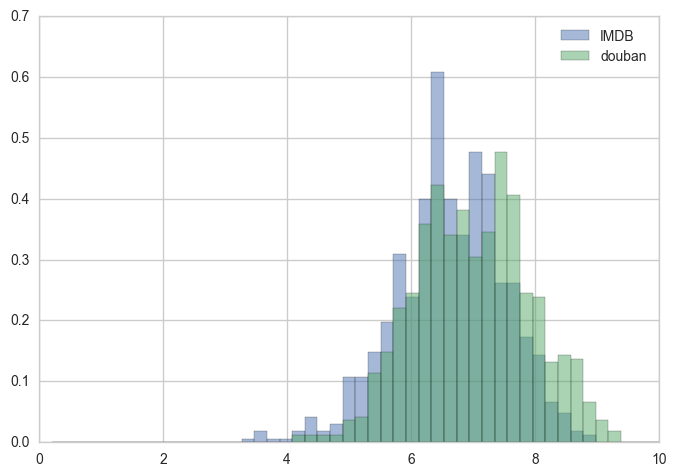

In [27]:
bins=linspace(0,10)
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins,alpha=0.5, normed=True, label = 'douban')
plt.legend()

### 4.1.1 Best Movies

In [28]:
# df.sort_values(by='imdb_rating',ascending=False).head()
movie_list(df.sort_values(by='imdb_rating',ascending=False)[:20])

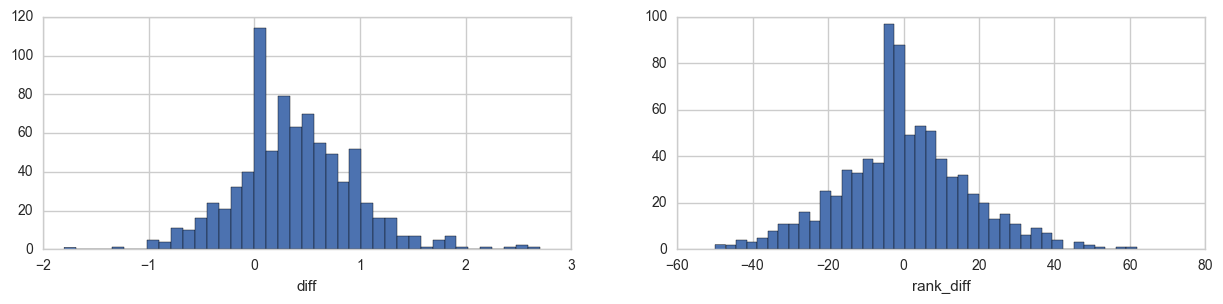

In [29]:
plt.subplot(1,2,1)
df['diff'].hist(bins=40,figsize=(15, 3))
plt.xlabel('diff')
plt.subplot(1,2,2)
df['rank_diff'].hist(bins=40)
plt.xlabel('rank_diff')

## 4.2 Scatter Comparison

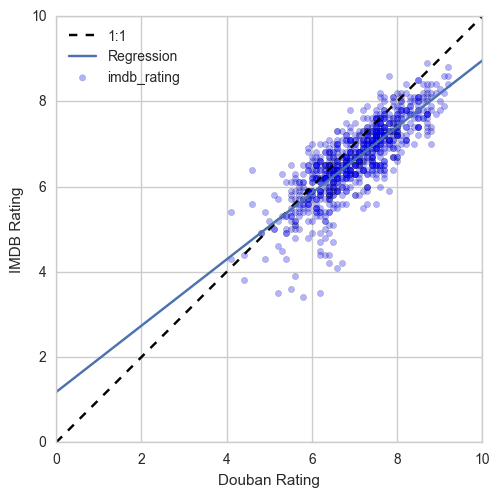

In [30]:
fig, _ , scatter_plot = plot_movie_scatter_comparison(df, title='')

In [31]:
turn_scatter_into_interactive(fig, scatter_plot, df, 'movie_compare.html')

D:\Program Files\Anaconda2\lib\site-packages\mpld3\mplexporter\exporter.py:171: UserWarning: Legend element <matplotlib.collections.PathCollection object at 0x0000000011EC45F8> not impemented
  warnings.warn("Legend element %s not impemented" % child)


1. 对比前后scatter plot, 总体趋势是不变的
2. Play with the Scatter Plot， 看看有哪些电影差别很大:

    1. 回归线以上，IMDB >> 豆瓣；回归线以下，豆瓣 >> IMDB
    2. 总体而言，豆瓣评分确实更分散，(7,4.5)附近的一个cluster, 可以算作典型的偏离
    3. 这些偏离的电影，有何规律？

## 4.3 Absolute Difference

先查看绝对分值差别大的电影， 再看相对差别大的电影（类似于回归线）

### 4.3.1 豆瓣 >> IMDB

In [32]:
# df.sort_values(by='diff',ascending=False).head()
movie_list(df.sort_values(by='diff',ascending=False))

### 4.3.2 IMDB >> 豆瓣

In [33]:
# df.sort_values(by='diff',ascending=False).head()
movie_list(df.sort_values(by='diff',ascending=True))

## 4.4 Rank Difference

### 4.4.1 Douban >> IMDB

In [34]:
# df.sort_values(by='rank_diff',ascending=False).head()
movie_list(df.sort_values(by='rank_diff',ascending=False))

### 4.4.1 IMDB >> 豆瓣

In [45]:
movie_list(df.sort_values(by='rank_diff',ascending=True))

我观察到的规律: 似乎很多动画的评分，差别很大，例如：
1. 蓝精灵
2. Rio
3. 冰川时代
4. 疯狂原始人

那么，是不是存在某类电影，评分差别会很大？

接下来，按类别分析

# 5. Genre Comparison

In [36]:
def category_overview(df, category):   
    sub_df = df[df['genre'].str.contains(category)]
    fig, _ , scatter_plot = plot_movie_scatter_comparison(sub_df)
    print len(sub_df)

In [37]:
for category in ["Romance", "Drama", "Action", 'Sci-Fi', 'Animation', 'Mystery', 'Crime', 'Adventure', 'Documentary', 'Comedy']:
    category_overview(df, category)
    plt_configure(title=category)
    plt.gcf().set_size_inches(2.5,2.5)
align_figures()

143
420
212
61
51
67
127
150
24
283


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQsAAAEWCAYAAABxHbIXAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAPYQAAD2EBqD+naQAAIABJREFUeJzsnXd4FOXah+/tm2TTeyAhJIQklIQQIHQwCioYBAQLior6
IVaK6EFFRESKWPAYRZCDCscjCBgRUIpKUXqvCZBAEtJ73V6+P5ashARIIA2Y+7q8ZGZn3nl2svvb
d573KSKLxWJBQEBA4DqIm9sAAQGBWwNBLAQEBOqEIBYCAgJ1QhALAQGBOiGIhYCAQJ0QxEJAQKBO
CGIhICBQJwSxEBAQqBOCWAgICNQJaXMbINCwjB07lgMHDlTbJxKJsLe3JzAwkKeeeophw4Y1k3UC
tzKCWNyGdOjQgZkzZ9q2TSYT2dnZfPfdd7zxxhu4uLjQv3//5jNQ4JZEEIvbEJVKRURERLV9UVFR
9O/fn169epGQkCCIhUC9EXwWdxByuRy5XI5IJAJAr9fzxRdfcP/99xMREcG9997L119/zeW5hWPH
jmXGjBksWrSI/v3706VLF8aPH09hYSFr165l8ODBREVFMW7cOLKysmznmc1mlixZQlxcHJGRkURF
RfHoo4+yb98+2zHx8fEMHjyYHTt2MGzYMDp37sy9997LunXrqtmdn5/Pv/71L3r37k3Xrl0ZO3Ys
R48etb1usVhYsmQJgwcPto3x3//+t7Fu4x2LMLO4DbFYLJhMJtu2yWQiIyODL774ArVazYMPPgjA
888/z/Hjx3nllVcIDQ1l7969LFy4kIsXLzJr1izb+Rs3bqRjx47MmTOH7Oxs3nvvPZ544gmUSiXT
pk1Do9Ewffp0Zs2axVdffQXAggULWLlyJVOnTiU0NJTc3Fzi4+OZOHEiO3bsQKFQAFYheP/993nx
xRfx9fVl6dKlTJs2jYiICNq2bYtarebRRx/FYrHwxhtv4O3tzbJly3jmmWf4+eefCQgI4N133yUh
IYEJEyYQFRXF/v37mTNnDuXl5bzwwgtNeOdvcywCtxVPPPGEJTQ0tMZ/YWFhlgcffNCyZcsWi8Vi
sWzfvt0SGhpq+fXXX6ud/+WXX1rCwsIsycnJtvEiIyMt5eXltmOee+45S1hYmCUjI8O27/3337d0
797dtj116lTLihUrqo29ZcsWS1hYmOXYsWMWi8Vi+fzzzy1hYWGWvXv32o7JysqyhIaGWr755huL
xWKxrFixwhIeHm5JSkqyHaPVai333XefZfXq1ZYLFy5YwsLCLEuXLq12rYULF1oiIyMtJSUl9b6H
ArUjzCxuQzp27Mj777+PxWIhLy+PTz/9FKPRyMKFCwkMDATgwIEDSKVS7rvvvmrnDhs2jM8++4z9
+/cTHBwMQFBQECqVynaMh4cHrq6utGrVyrbPxcWF8vJy2/aCBQsAKCoq4sKFC6SlpbFt2zbA+vhz
OV26dLH928fHBwC1Wg3A4cOHad26NaGhobZjFAoFv/32GwArV64EYODAgdVmU3fddReLFi3i4MGD
3H333XW+dwJXRxCL2xAHBwc6dOgAWIUjIiKCYcOGMW7cOBISEnBxcaG0tBRXV1eb/6IKT09PgGpf
/MuFogo7O7tr2nDixAnee+89Tp48iZ2dHSEhIfj6+gJU84kAtkcSwGaP2WwGoKSkBDc3t6tep6Sk
BIvFwtChQ2u8JhKJyMvLu6adAnVHEIs7AHd3d2bMmMHEiROZPXs2H330Ec7OzhQXF2OxWKoJRtWX
y9XV9YavV1FRwf/93/8RHh7Or7/+SlBQEAA7duxgy5Yt9RrL0dGRzMzMGvuPHDmCk5MTjo6OiEQi
li9fjr29fY3jqgRK4OYRVkPuEO6991769evHxo0bOXjwIN27d8doNNqm81WsW7cOkUhEdHT0DV/r
/PnzlJSUMHbsWJtQAOzcuRP4Z9ZQF7p168bFixdJSUmx7dPpdLzyyiusXbuW7t27Y7FYKCoqomPH
jrb/CgoKWLhwISUlJTf8PgSqI8ws7iDeeust4uLimD17Nj/99BMxMTG888475ObmEhYWxr59+1i6
dCkjRoyo9iWvL1U+jq+++gqJRIJUKmXz5s2sWbMGAI1GU+exRo4cyYoVK3jhhRd45ZVXcHV15bvv
vsNgMPDEE0/g5+fHsGHDeOedd8jIyKBTp06cP3+ehQsX4u/vT9u2bW/4fQhUR5hZ3IZc6Yeoom3b
tjz55JOcOXOGH374gSVLlvDII4/w3Xff8fzzz7NlyxamTp3KnDlzrjvetfapVCoWLVqExWJh0qRJ
/Otf/yInJ4fvv/8eBwcHDh48eN1xqvY7ODjw/fffExkZyezZs5k8eTIWi4UVK1bg5+cHwLx58xg3
bhyrVq3iueeeY8mSJTzwwAMsW7bsqvdCoP6ILFd6mwQEBARqoUXNLPR6PXFxcdUSoTIyMhg3bhxR
UVE88MAD7Nq1qxktFBC4c2kxYqHX65kyZQrJycnV9r/00kt4eXmxdu1ahg0bxssvv0xOTk4zWSkg
cOfSIsQiJSWFhx9+mIyMjGr79+zZYws9DgoKYvz48XTp0sXmKBMQEGg6WoRY7N+/n169erFq1apq
ATvHjx+nY8eO1YJ2oqOjqyURCQgINA0tYun0scceq3V/fn4+Xl5e1fa5u7uTm5vbFGYJCAhcRouY
WVwNjUaDXC6vtk8ul9fILRAQEGh8WsTM4mooFApKS0ur7dPr9SiVyjqdbzQaKS0tRaFQIBa3aF0U
EGg0zGYzOp0OZ2dnpNIb/8q3aLHw9vausTpSUFBgS3a6HqWlpaSmpjaCZQICtx6BgYG4u7vf8Pkt
WiwiIyP5+uuv0ev1tseRQ4cO0a1btzqdX+UY9fDwqDVzsjnR6XRkZ2fj6+tbzYHbEmiptrVUu6Bl
2WYwGJg+fTp///03YC078Mgjj9y0XS1aLHr06IGvry/Tpk3jxRdf5M8//+TEiRPMmzevTudXPXqo
VKqbUtTGQK1Wk52djYuLS63Zks1JS7WtpdoFLcc2nU7H6NGjWb9+PQBxcXG89tprZGRk3PSjeIt7
kL88ll8sFvPll1+Sn5/PQw89xPr16/niiy9sBVIEBAT+wWAw1BCKNWvW3JSf4nJa3MwiMTGx2ra/
vz8rVqxoJmsEBG4dpFIpoaGhrF+/3iYUV64m3tT4DTaSgIBAsyISifjwww/p2LEjY8aMaVChAEEs
BARuK0QiEU8//XSjjN3ifBYCAgItE0EsBAQE6oQgFgICtxh6vR6j0djk1xXEQkDgFkKn0zFq1Cge
f/zxJhcMwcEpIHCLcGXAVUxMDFOmTGmy6wszCwGBW4DaIjNffvnlJrVBEItbmNpqll6NgwcPcs89
9zSBVQINTW1C0dABV3VBEItblKvVLK2NM2fOMGnSpBptAwVaPi1FKEAQi1uSq9UsrY2VK1fy2GOP
4eHh0QSWCTQ048ePbxFCAYKDs1b27dt3zdfbtWt3zSzWwsLC6/7id+7c+YZsg39qlk6aNInIyMhq
r4WFhTFv3jyGDx8OwN9//82HH35IeXk58fHxN3xNgeZh0qRJbNiwgT59+jSrUIAgFrXSs2fPa77+
448/Mnr06Ku+/ueff/Lwww9fc4zKysobsg2uXrMUYNeuXTg6Otq2qwQiISHhhq8n0HxERUWxZ88e
AgMDb0goSsp1JOy8QFTAzXdmE8TiNqOl1e0QuHnat29/Q+elZpfx/n/2IsFIVID3TdshiEUt7N27
95qvt2vX7pqvx8bGXncMAYHGZP+pHD76/iAanQlfV1mDjCmIRS3ExMTc1Pnu7u7X/YVXq9U3dQ0B
gdqwWCwkbE/m242nsVhAKhHx0F1BwI0/9lYhiIWAQDOj0+lIT08nJCTkpsYxGE3Erz7GnwcvAuDk
IOetp3vg4wy

可以发现，动画和其他类别，显著不同。具体画如下

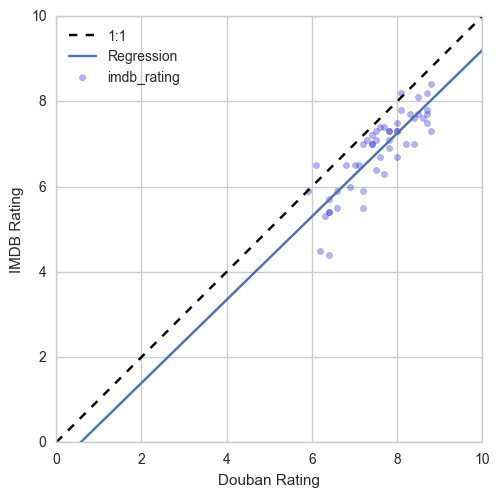

In [38]:
sub_df = df[df['genre'].str.contains('Animation')]
fig, _ , scatter_plot = plot_movie_scatter_comparison(sub_df)

In [39]:
turn_scatter_into_interactive(fig, scatter_plot, sub_df, 'animation.html')

D:\Program Files\Anaconda2\lib\site-packages\mpld3\mplexporter\exporter.py:171: UserWarning: Legend element <matplotlib.collections.PathCollection object at 0x0000000014818DA0> not impemented
  warnings.warn("Legend element %s not impemented" % child)
